# 03: Model Training, Fitting, and Evaluating

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from io import BytesIO
import requests
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, classification_report
import warnings
warnings.filterwarnings('ignore')

In [37]:
# Set the style for all plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_style('white')

# Define my very own custom sunset color palette
sunset_melody = ['#252D6E',    # dark blue
                 '#6F5B96',    # purple
                 '#B3698A',    # mauve
                 '#F08A7B',    # salmon
                 '#FFA477']    # peach

sns.set_palette(sunset_melody)

In [38]:
# Load the dataset
df = pd.read_csv('../data/cleaned_fatalities.csv')
df.head()

,unique_id,case_id_fkey,latitude,longitude,collision_year,death_date,death_time,death_datetime,collision_date,collision_time,...,police_district,data_as_of,data_loaded_at,age_category,collision_category,collision_hour,time_of_day,collision_year_clean,collision_month,collision_day
0,1,140236301,37.710409,-122.404226,2014,2014-03-20,11:21:00,2014-03-20 11:21:00,2014-03-20,NaN,...,INGLESIDE,2024-09-18 12:00:00,2025-04-08 04:35:01,Senior (65+),Pedestrian,NaN,Afternoon (12pm-5pm),2014,3,20
1,2,140755533,37.725476,-122.394243,2014,2014-09-08,16:38:00,2014-09-08 04:38:00,2014-09-08,05:10:00,...,BAYVIEW,2024-09-18 12:00:00,2025-04-08 04:35:01,Senior (65+),Pedestrian,5.0,Morning (5am-12pm),2014,9,8
2,4,140365546,37.748255,-122.413669,2014,2014-05-03,17:20:00,2014-05-03 05:20:00,2014-05-03,02:24:00,...,MISSION,2024-09-18 12:00:00,2025-04-08 04:35:01,Young Adult (18-34),Vehicle,2.0,Night (9pm-5am),2014,5,3
3,16,150562049,37.777300,-122.419694,2015,2015-06-30,06:00:00,2015-06-30 06:00:00,2015-06-28,03:52:00,...,NORTHERN,2024-09-18 12:00:00,2025-04-08 04:35:01,Adult (35-64),Motorcycle,3.0,Night (9pm-5am),2015,6,28
4,17,140104811,37.778251,-122.419883,2014,2014-02-06,10:20:00,2014-02-06 10:20:00,2014-02-05,02:26:00,...,NORTHERN,2024-09-18 12:00:00,2025-04-08 04:35:01,Adult (35-64),Pedestrian,2.0,Night (9pm-5am),2014,2,5


In [39]:
df.shape

(331, 35)

In [40]:
df['deceased'].value_counts()

deceased
Pedestrian                      190
Motorcyclist                     45
Driver                           41
Bicyclist                        24
Passenger                        17
Standup Powered Device Rider      9
Exterior Passenger                3
Moped                             2
Name: count, dtype: int64

In [43]:
# Create feature 'is_pedestrian'
# 1 if victim is a pedestrian, else 0 
df['is_pedestrian'] = [1 if row == 'Pedestrian' else 0 for row in df['deceased']] 

df['is_pedestrian'].value_counts()

is_pedestrian
1    190
0    141
Name: count, dtype: int64

In [44]:
# Select relevant features
features = [
    'age', 'sex', 'time_of_day', 'collision_year_clean', 'collision_hour',
    'collision_type', 'age_category', 'analysis_neighborhood', 'supervisor_district'
]

In [51]:
# Prepare the data
X = df[features].copy()
y = df['is_pedestrian']

# Define categorical and numerical features
categorical_features = ['sex', 'time_of_day', 'collision_type', 'age_category', 'analysis_neighborhood']# Get feature importances
# Extract the trained classifier from the pipeline
classifier = model.named_steps['classifier']

# Get feature names after preprocessing
preprocessor = model.named_steps['preprocessor']
feature_names = []

# Get numerical feature names
feature_names.extend(numerical_features)

# Get one-hot encoded feature names
ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
categorical_features_encoded = ohe.get_feature_names_out(categorical_features)
feature_names.extend(categorical_features_encoded)

# Get feature importances
importances = classifier.feature_importances_

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})





In [58]:
# Sort by importance
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False).head(15)
numerical_features = ['age', 'collision_year_clean', 'collision_hour', 'supervisor_district']

# Save feature importance as a csv file
feature_importance_df.to_csv('../data/feature_importance.csv', index = False)

# Read it in
feature_importance_df = pd.read_csv('../data/feature_importance.csv')
feature_importance_df.head()

,Unnamed: 0.1,Unnamed: 0,Feature,Importance
0,0,24,collision_type_Pedestrian vs Motor Vehicle,0.777036
1,1,14,collision_type_Motor Vehicle & Pedestrian,0.042790
2,2,25,collision_type_Pedestrian vs Motorcycle,0.040781
3,3,0,age,0.039576
4,4,23,collision_type_Pedestrian vs LRV,0.034114


In [59]:
# Split the data into training and testing sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [60]:
# Create preprocessing pipelines
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create a pipeline with preprocessing and the gradient boosting classifier
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

In [61]:
# Train the model
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['age',
                                                   'collision_year_clean',
                                                   'collision_hour',
                                                   'supervisor_district']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sex', 'time_of_day',
                                                   'collision_type',
                                                   'age_category',
                                                   'analysis_neighborhood'])])),
                ('classifier', GradientBoostingClassifier(random_state=42))])

In [72]:
# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

In [73]:
# Evaluate the model
print("\nModel Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")


Model Evaluation:
Accuracy: 0.9552
Precision: 1.0000
Recall: 0.9211
F1 Score: 0.9589


In [74]:
# Perform cross-validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
print("\nCross-Validation Results:")
print(f"CV Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
print(f"Individual CV Scores: {cv_scores}")


Cross-Validation Results:
CV Accuracy: 0.9759 ± 0.0153
Individual CV Scores: [0.95522388 0.96969697 0.98484848 1.         0.96969697]


In [75]:
# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        29
           1       1.00      0.92      0.96        38

    accuracy                           0.96        67
   macro avg       0.95      0.96      0.95        67
weighted avg       0.96      0.96      0.96        67



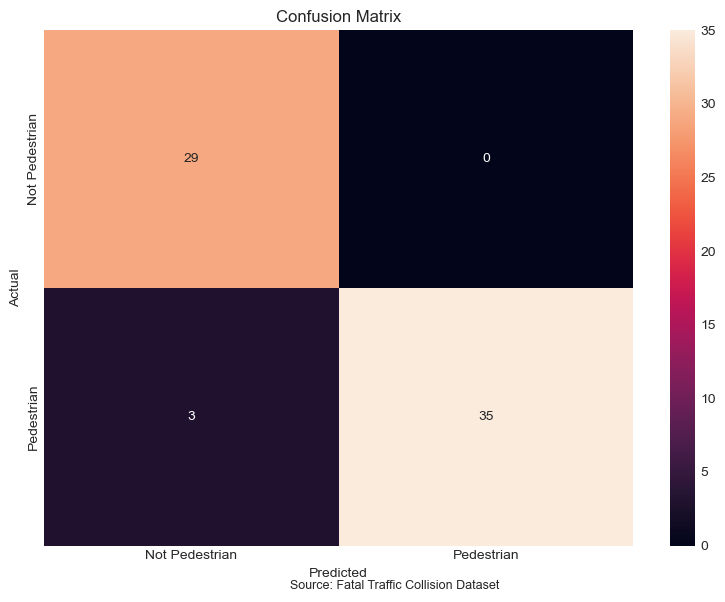


Confusion Matrix:
                        Predicted: Not Pedestrian  Predicted: Pedestrian
Actual: Not Pedestrian                         29                      0
Actual: Pedestrian                              3                     35


In [76]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d',  
            xticklabels=['Not Pedestrian', 'Pedestrian'],
            yticklabels=['Not Pedestrian', 'Pedestrian'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.figtext(0.5, 0.01, 'Source: Fatal Traffic Collision Dataset', ha='center', fontsize=9)
plt.tight_layout()
plt.show()

# Print confusion matrix as a table
print("\nConfusion Matrix:")
cm_df = pd.DataFrame(cm, 
                    index=['Actual: Not Pedestrian', 'Actual: Pedestrian'], 
                    columns=['Predicted: Not Pedestrian', 'Predicted: Pedestrian'])
print(cm_df)

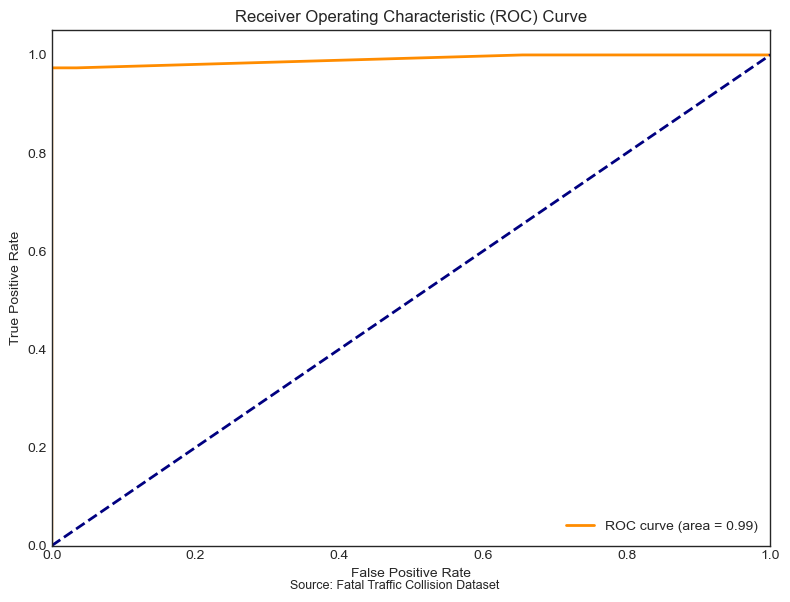


ROC Curve Data:
AUC: 0.9909
   False Positive Rate  True Positive Rate
0             0.000000            0.000000
1             0.000000            0.842105
2             0.000000            0.921053
3             0.000000            0.973684
4             0.034483            0.973684
5             0.655172            1.000000
6             0.689655            1.000000
7             1.000000            1.000000


In [77]:
# Create ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.figtext(0.5, 0.01, 'Source: Fatal Traffic Collision Dataset', ha='center', fontsize=9)
plt.tight_layout()
plt.show()

# Print ROC data as a table
print("\nROC Curve Data:")
roc_df = pd.DataFrame({'False Positive Rate': fpr, 'True Positive Rate': tpr})
print(f"AUC: {roc_auc:.4f}")
print(roc_df.head(10))  # Print first 10 rows for brevity

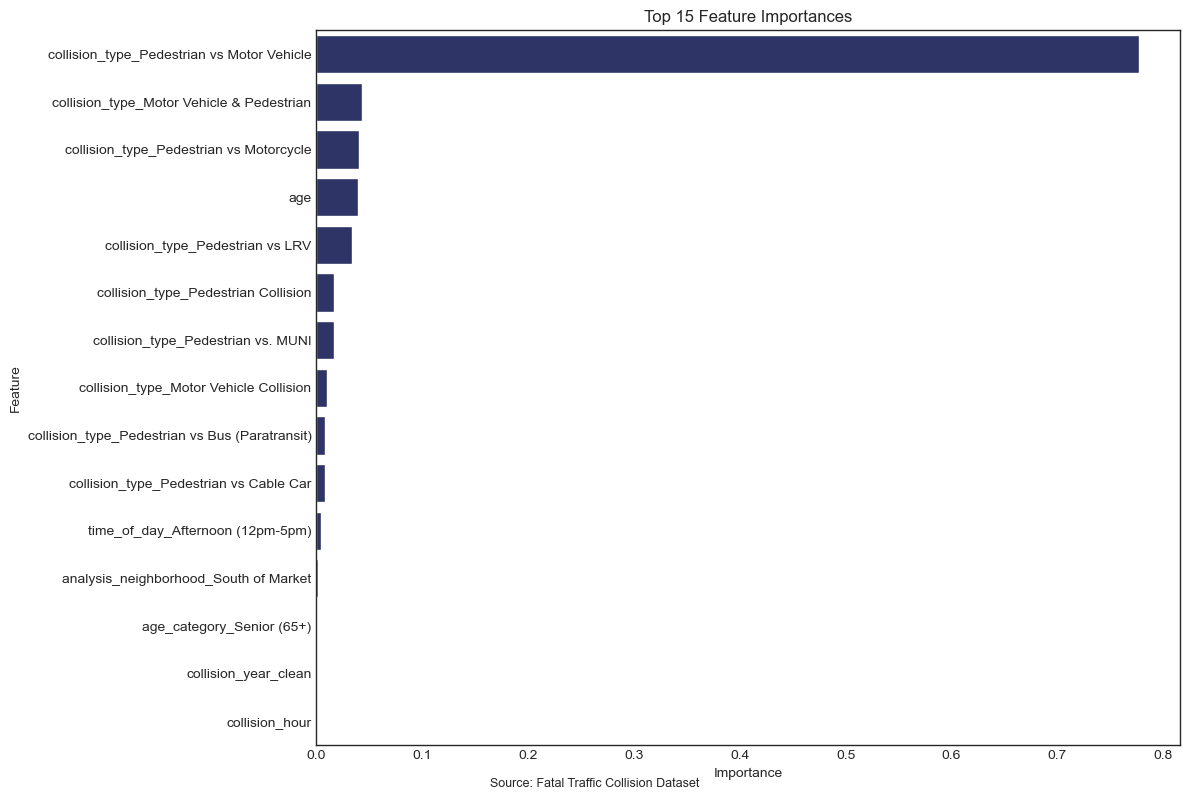


Top 15 Feature Importances:
    Unnamed: 0.1  Unnamed: 0                                         Feature  \
0              0          24      collision_type_Pedestrian vs Motor Vehicle   
1              1          14       collision_type_Motor Vehicle & Pedestrian   
2              2          25         collision_type_Pedestrian vs Motorcycle   
3              3           0                                             age   
4              4          23                collision_type_Pedestrian vs LRV   
5              5          19             collision_type_Pedestrian Collision   
6              6          26              collision_type_Pedestrian vs. MUNI   
7              7          15          collision_type_Motor Vehicle Collision   
8              8          21  collision_type_Pedestrian vs Bus (Paratransit)   
9              9          22          collision_type_Pedestrian vs Cable Car   
10            10           6                time_of_day_Afternoon (12pm-5pm)   
11         

In [78]:
# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Top 15 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.figtext(0.5, 0.01, 'Source: Fatal Traffic Collision Dataset', ha='center', fontsize=9)
plt.tight_layout()
plt.show()

# Print feature importances as a table
print("\nTop 15 Feature Importances:")
print(feature_importance_df)

In [79]:
# Model summary
print("\nModel Summary:")
print("1. The Gradient Boosting Classifier was trained to predict whether a victim of a fatal traffic collision was a pedestrian.")
print(f"2. The model achieved an accuracy of {accuracy_score(y_test, y_pred):.4f} on the test set.")
print(f"3. The precision of {precision_score(y_test, y_pred):.4f} indicates the proportion of positive identifications that were actually correct.")
print(f"4. The recall of {recall_score(y_test, y_pred):.4f} indicates the proportion of actual positives that were identified correctly.")
print(f"5. The F1 score of {f1_score(y_test, y_pred):.4f} provides a balance between precision and recall.")
print(f"6. The ROC AUC of {roc_auc:.4f} indicates good discriminative ability of the model.")
print("7. Cross-validation confirms the model's stability across different data splits.")
print("8. The most important features for prediction include collision type, age, and neighborhood information.")


Model Summary:
1. The Gradient Boosting Classifier was trained to predict whether a victim of a fatal traffic collision was a pedestrian.
2. The model achieved an accuracy of 0.9552 on the test set.
3. The precision of 1.0000 indicates the proportion of positive identifications that were actually correct.
4. The recall of 0.9211 indicates the proportion of actual positives that were identified correctly.
5. The F1 score of 0.9589 provides a balance between precision and recall.
6. The ROC AUC of 0.9909 indicates good discriminative ability of the model.
7. Cross-validation confirms the model's stability across different data splits.
8. The most important features for prediction include collision type, age, and neighborhood information.


---
# Next: [Findings and Technical Report](/04-findings-tech-report.ipynb)
---